In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Mount Google Drive (Optional)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: Define File Paths
data_path = "/content/drive/MyDrive/Saint Mary 2024-2025/Data 496/IRRS work/OCED Data/"  # Update this if needed

# List of dataset filenames and corresponding factor names
datasets = {
    "Corruption_index_Cleaned.csv": "Corruption",
    "Unemployment_rate_ Cleaned.csv": "Unemployment",
    "Filtered_Public_Sector_Debt_Cleaned.csv": "Public_Sector_Debt",
    "Population_growth_rate_Cleaned.csv": "Population_Growth",
    "Political_stability_Cleaned.csv": "Political_Stability",
    "National_GDP_in_USD_Cleaned.csv": "GDP",
    "Foreign_direct_investment_Cleaned in USD.csv": "Foreign_Investment",
    "birth_rate_cleaned.csv": "Birth_Rate"
}

In [ ]:
# Step 3: Read and Reshape Each Dataset
df_list = []

for file, factor in datasets.items():
    # Read dataset
    data = pd.read_csv(data_path + file)

    # Identify valid year columns (numeric) + 'Country' + 'CCode'
    year_columns = [col for col in data.columns if col.isdigit()]  # Keep only year columns
    selected_columns = ["Country", "CCode"] + year_columns  # Add Country and Country Code

    # Keep only relevant columns
    data = data[selected_columns]

    # Convert from wide to long format
    data_long = pd.melt(data, id_vars=["Country", "CCode"], var_name="Year", value_name=factor)

    # Convert Year column to integer
    data_long["Year"] = data_long["Year"].astype(int)

    # Store transformed dataset
    df_list.append(data_long)

In [ ]:
# Step 4: Merge All DataFrames with Outer Join to Include All OECD Countries
df_long = df_list[0]  # Start with the first dataset

for d in df_list[1:]:
    df_long = pd.merge(df_long, d, on=["Country", "CCode", "Year"], how="outer")  # Outer join to include all countries

# Check for missing countries
missing_countries = df_long[df_long.isnull().any(axis=1)]["Country"].unique()
print(f"Missing countries: {missing_countries}")

Missing countries: ['Czech Republic' 'Korea' 'Slovak Republic' 'Turkey' 'United States']


In [ ]:
# Step 6: Handle Missing Data
fill_strategy = "median"  # Change to "zero" if you want to replace with 0
factors = list(datasets.values())

if fill_strategy == "median":
    for factor in factors:
        df_long[factor].fillna(df_long[factor].median(), inplace=True)  # Fill with median
elif fill_strategy == "zero":
    df_long[factors] = df_long[factors].fillna(0)  # Fill all missing values with 0

<ipython-input-47-972f345375b6>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_long[factor].fillna(df_long[factor].median(), inplace=True)  # Fill with median


In [ ]:
# Step 7: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 100))
factors = list(datasets.values())  # List of factor names
df_long[factors] = scaler.fit_transform(df_long[factors])

In [ ]:
# Step 8: Assign proper weights (Negative weights for negative factors)
real_estate_weights = {
    "Population_Growth": 0.357,
    "GDP": 0.214,
    "Foreign_Investment": 0.214,
    "Political_Stability": 0.143,
    "Corruption": -0.143,  # Negative effect
    "Unemployment": -0.143,  # Negative effect
    "Public_Sector_Debt": -0.071,  # Negative effect
    "Birth_Rate": 0.143
}


In [ ]:
# Step 7: Compute Real Estate assessment score
df_long["Real_Estate_Investment_Score"] = sum(df_long[factor] * weight for factor, weight in real_estate_weights.items())

In [ ]:
# Step 8: Save the dataset
df_long.to_csv("/content/OECD_Real_Estate_Investment_Scores.csv", index=False)
print("Real estate investment scores saved successfully!")

Real estate investment scores saved successfully!


In [ ]:
df_long

,Country,CCode,Year,Corruption,Unemployment,Public_Sector_Debt,Population_Growth,Political_Stability,GDP,Foreign_Investment,Birth_Rate,Real_Estate_Investment_Score
0,Australia,AUS,2010,88.927941,12.461532,4.898157,74.427466,76.846741,4.096766,41.996638,55.790121,40.555201
1,Australia,AUS,2011,89.345617,11.951229,6.130595,71.340355,78.330756,4.998237,45.656112,54.382729,40.365844
2,Australia,AUS,2012,87.581174,12.504382,7.138045,77.959213,80.303747,5.535719,44.680168,54.874633,43.089112
3,Australia,AUS,2013,81.748340,14.210588,8.038094,77.500945,81.351445,5.642515,44.302491,53.064152,43.284668
4,Australia,AUS,2014,83.835200,15.827198,9.537177,73.235939,81.386891,5.249654,45.366783,49.900936,40.822445
...,...,...,...,...,...,...,...,...,...,...,...,...
513,United States,USA,2019,64.295010,6.443068,39.924943,53.986700,52.438648,77.692600,76.177243,33.224021,51.500944
514,United States,USA,2020,60.131597,23.528495,50.933676,63.528199,47.807710,77.021649,54.369517,33.224021,46.805130
515,United States,USA,2021,59.589593,12.987418,48.811522,48.450030,48.234543,85.420625,95.657298,33.224021,53.851780
516,United States,USA,2022,62.068711,6.369055,47.268314,52.353620,48.967055,93.814548,87.512463,33.224021,56.104896


<ipython-input-53-b85350ec2c21>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_countries = df_long.groupby("Year").apply(lambda x: x.nlargest(10, "Real_Estate_Investment_Score"))


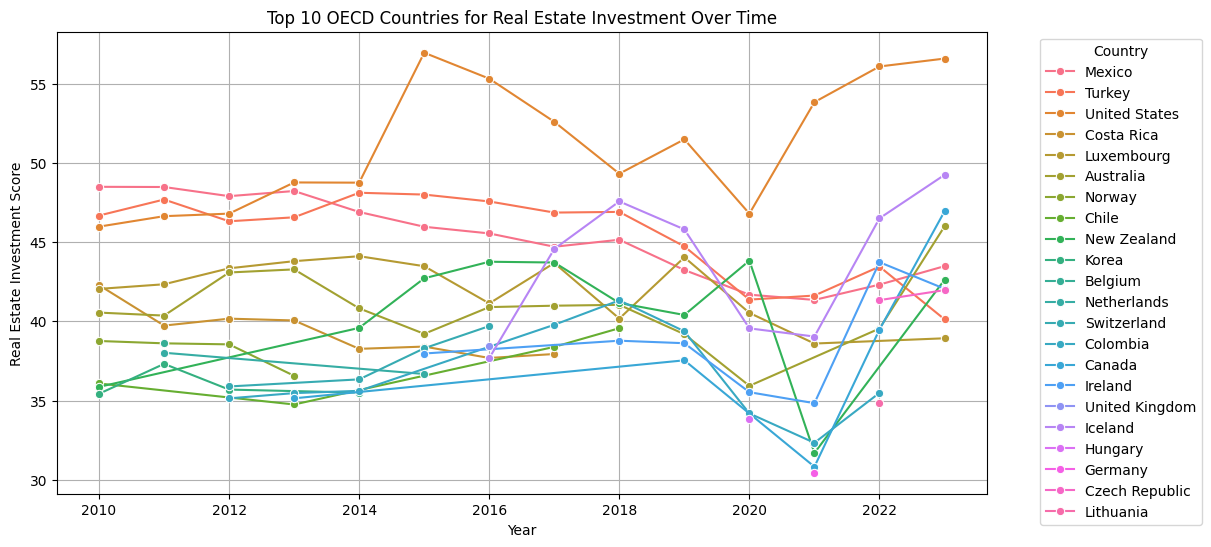

In [ ]:
#Step 9 Visualize the top countries for real estate investment
# Select top 5 real estate investment scores per year
top_countries = df_long.groupby("Year").apply(lambda x: x.nlargest(10, "Real_Estate_Investment_Score"))

# Plot investment scores over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_countries, x="Year", y="Real_Estate_Investment_Score", hue="Country", marker="o")
plt.title("Top 10 OECD Countries for Real Estate Investment Over Time")
plt.xlabel("Year")
plt.ylabel("Real Estate Investment Score")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()

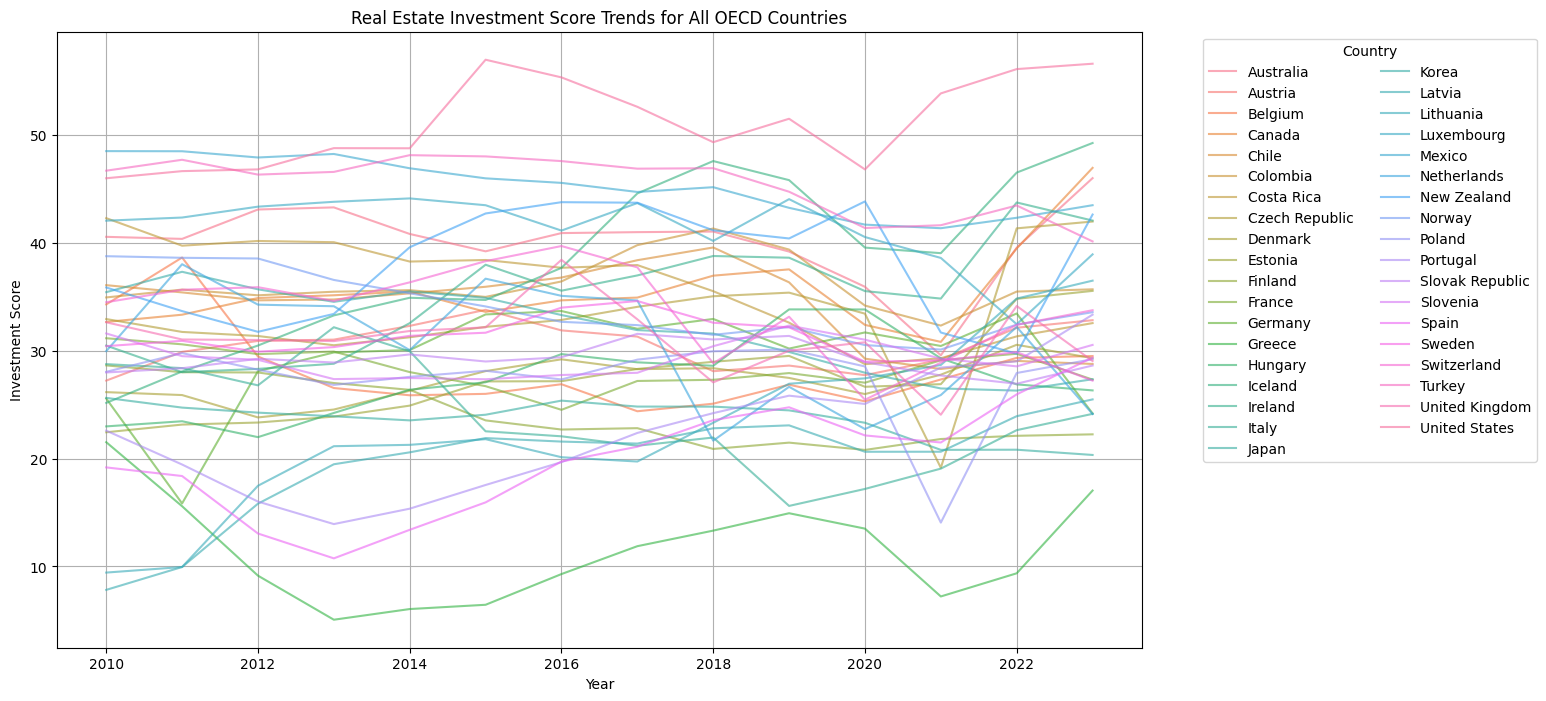

In [ ]:
plt.figure(figsize=(14, 8))

# Plot the trend of real estate investment scores for all countries
sns.lineplot(data=df_long, x="Year", y="Real_Estate_Investment_Score", hue="Country", alpha=0.6)

plt.title("Real Estate Investment Score Trends for All OECD Countries")
plt.xlabel("Year")
plt.ylabel("Investment Score")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2)
plt.grid()
plt.show()

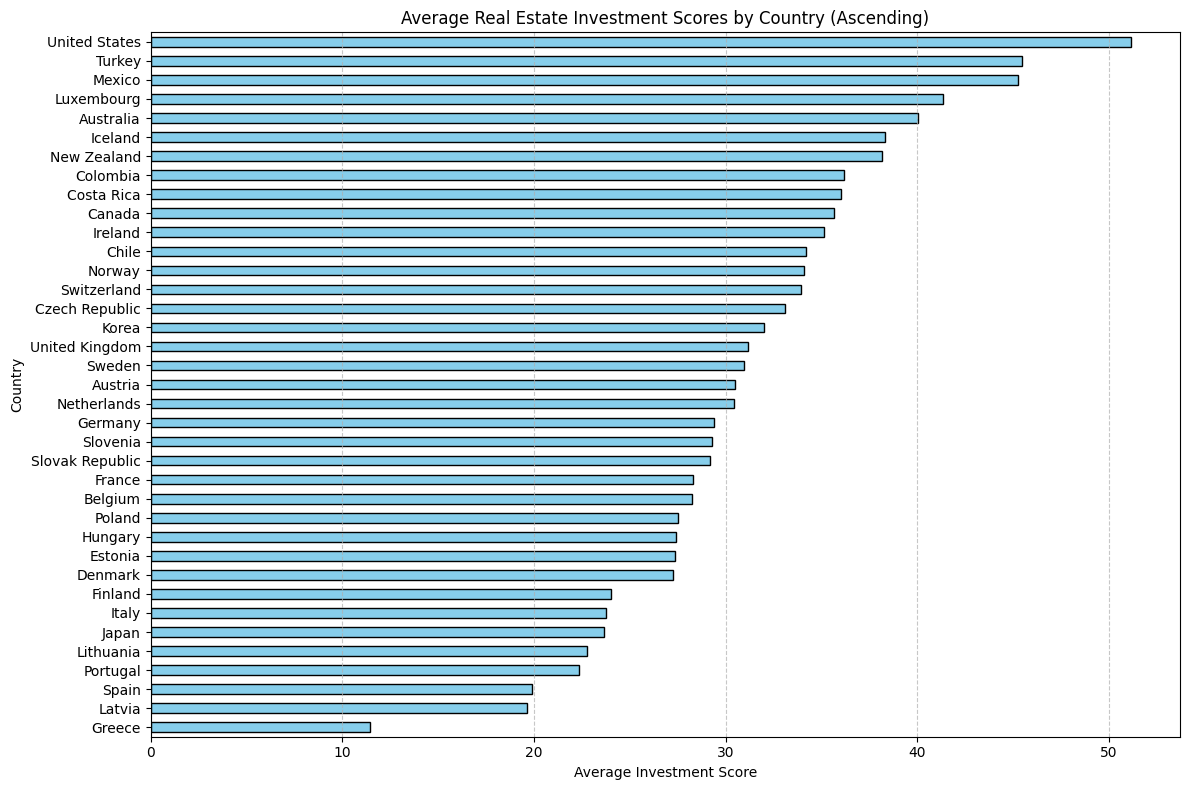

,Real_Estate_Investment_Score
Country,
Ireland,35.158465
Canada,35.631467
Costa Rica,36.043567
Colombia,36.171187
New Zealand,38.137255
Iceland,38.329656
Australia,40.035796
Luxembourg,41.337382
Mexico,45.253910


In [ ]:
#Bar graph
# Calculate the average investment score per country
country_avg_score = df_long.groupby("Country")["Real_Estate_Investment_Score"].mean()

# Sort countries by the average score in ascending order
country_avg_score_sorted = country_avg_score.sort_values(ascending=True)

# Plot a bar graph
plt.figure(figsize=(12, 8))
country_avg_score_sorted.plot(kind="barh", color='skyblue', edgecolor='black')

# Customize plot
plt.title("Average Real Estate Investment Scores by Country (Ascending)")
plt.xlabel("Average Investment Score")
plt.ylabel("Country")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

country_avg_score_sorted[-11:]